<a href="https://colab.research.google.com/github/HemantTiwariGitHub/Embedding2Embedding/blob/master/TheTrainerVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 try:
    %tensorflow_version 2.x
except:
    pass

In [120]:
import tensorflow as tf
import tensorflow_hub as hub
from absl import logging
import numpy as np
from PIL import Image as PIL_Image
from io import StringIO
import numpy as np
import PIL.Image as Image
import pathlib


print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.1.0-rc1
• Using TensorFlow Hub Version:  0.7.0
• GPU Device Not Found. Running on CPU


In [18]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [0]:
MOBILENET_V2_FEATURE_EXTRACTOR_URI = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
PIXEL =224
INPUT_IMAGE_SIZE = (PIXEL, PIXEL)
OUTPUT_FEATURE_VECTOR_SIZE = 1280
feature_extractor = hub.KerasLayer(MOBILENET_V2_FEATURE_EXTRACTOR_URI,
                                   input_shape=INPUT_IMAGE_SIZE + (3,), 
                                   output_shape=[OUTPUT_FEATURE_VECTOR_SIZE],
                                   trainable=False)
model = tf.keras.Sequential([
        feature_extractor
])

In [0]:
def resize_image(image):
    #print("resizing:") 
    resized_img = image.resize(INPUT_IMAGE_SIZE)
    #resized_img.show()
    resized_img_arr = np.array(resized_img)/255.0
    return resized_img_arr

def getImageEmbedding(regionImage, model):
    resizedImage = resize_image(regionImage)
    #plt.imshow(resizedImage)
    #plt.show()
    embedding = model.predict(resizedImage[np.newaxis, ...])
    #print(embedding)
    return embedding

In [0]:
def readImageFromDrive(imgId, regId):
    drivepath = '/content/drive/My Drive/'
    imagepath = drivepath +  'Region_Image/Image_' + str(imgId)+'_Region_' + str(regId)+'.jpg'
    imageName =  str(imgId) + '_' + str(regId)
    imageGet = tf.keras.utils.get_file(imageName, pathlib.Path(imagepath).as_uri())
    imageRead = Image.open(imageGet)
    return imageRead

40960/38400 [================================] - 0s 7us/step


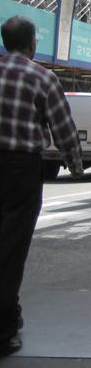

In [125]:
#imgReg = readImageFromDrive(125,2)
#imgReg

In [0]:
def readTextFromDrive(imgId, regID):

    drivepath = '/content/drive/My Drive/'
    IembeddingPath = drivepath+'/Region_Descp'
    descpath =  drivepath + 'Region_Descp/Image_' + str(imgId)+'_Region_Descp' + str(regID)+'.txt'
    f = open(descpath, 'r')
    content = f.read()
    return content

In [0]:
def readEmbeddingFromDrive(imgId, regID):

    drivepath = '/content/drive/My Drive/'
    IembeddingPath = drivepath+'/Region_Descp'
    descpath =  drivepath + 'Image_Embedding/Image_' + str(imgId)+'_Embedding_'+ str(regID)+'.txt'
    f = open(descpath, 'r')
    content = f.read()
    return content


In [0]:
!unzip <filename>

In [0]:
def getFileList(path):
    import glob,os
    iwd = os.getcwd()
    os.chdir(path)
    filelist= []
    for file in glob.glob("*.txt"):
        filelist.append(file)
    os.chdir(iwd)
    return filelist

In [0]:
import re
def getImageIDregID(str1):
    idList = list(map(int, re.findall('\d+',str1)))
    return idList

In [0]:
def getAllPairs(loadpath):
  ListOfFiles = getFileList(loadpath)
  ListOfID = []
  for filename in ListOfFiles:
    #print(filename)
    ID,REGID = getImageIDregID(filename)
    ListOfID.append([ID,REGID])
  return ListOfID

In [0]:
LOADING_PATH = "/content/Region_Descp"
ListOfIDs = getAllPairs(LOADING_PATH)

#print(ListOfIDs)

In [0]:
def LoadBatch(baseIndex, batchSize, sourceList):
    maxIndex = baseIndex + batchSize
    xList = []
    yList = []
    while (baseIndex < maxIndex):
        if (baseIndex%10==0):
          print("reading index" + str(baseIndex))
        description = readTextFromDrive(sourceList[baseIndex][0], sourceList[baseIndex][1])
        x = embed([description])
        y = readEmbeddingFromDrive(sourceList[baseIndex][0], sourceList[baseIndex][1])

        xList.append(x)
        yList.append(y)
        baseIndex = baseIndex + 1

    return xList,yList

In [96]:
X,Y = LoadBatch(0, 100, ListOfIDs)

reading index0
reading index10
reading index20
reading index30
reading index40
reading index50
reading index60
reading index70
reading index80
reading index90


In [104]:
print(tf.convert_to_tensor(Y[1]))

tf.Tensor(b'[[1.32233644e+00 1.45155460e-01 0.00000000e+00 0.00000000e+00\n  0.00000000e+00 7.37679750e-02 0.00000000e+00 4.80522573e-01\n  6.26416862e-01 0.00000000e+00 0.00000000e+00 6.15130901e-01\n  9.62062180e-02 2.88364202e-01 3.58558679e+00 3.96230668e-01\n  0.00000000e+00 5.20413756e-01 1.46514148e-01 1.90604886e-03\n  0.00000000e+00 0.00000000e+00 1.49549949e+00 2.04533651e-01\n  3.90604675e-01 0.00000000e+00 0.00000000e+00 4.96787024e+00\n  1.45400167e-02 1.85327065e+00 0.00000000e+00 0.00000000e+00\n  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n  0.00000000e+00 0.00000000e+00 1.46235955e+00 0.00000000e+00\n  3.99642229e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00\n  7.55478144e-01 0.00000000e+00 0.00000000e+00 1.32016644e-01\n  5.70940733e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00\n  0.00000000e+00 6.61081029e-03 0.00000000e+00 1.99007932e-02\n  9.99890715e-02 0.00000000e+00 0.00000000e+00 7.15155542e-01\n  2.20424905e-01 1.21228129e-01 1.03333462e

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

tf.keras.backend.clear_session() 

In [0]:
print()